In [1]:
import numpy as np
import pandas as pd
import os
from itertools import groupby
from operator import itemgetter
from aicsimageio.readers import OmeTiffReader
from aicsimageio.writers import OmeTiffWriter
from CustomFunctions import RotateImage
import multiprocessing
from CustomFunctions.PCanimation import interpolate_contour_shapes, mesh_from_bins, interpolate_transitions_by_time
import pickle as pk
from scipy import interpolate
from scipy.spatial import distance
from cmocean import cm
import matplotlib
from matplotlib.animation import FuncAnimation 
import matplotlib.pyplot as plt

def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)


In [2]:
########## find a cell of interest ###########
fl = 'D:/Aaron/Data/Chem_Galv_Combined/'
savedir = fl + 'Data_and_Figs/'
infrsavedir = 'D:/Aaron/Data/Galvanotaxis/Data_and_Figs/Inframe_Videos/'

TotalFrame = pd.read_csv(savedir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

#lmax used to generate the shcoeffs
lmax = 10

#get changes in PCs between consecutive frames of a movie
nbins = 11

#first bin PCs
hist1, PC1bins = np.histogram(TotalFrame.PC1, nbins)
hist2, PC2bins = np.histogram(TotalFrame.PC2, nbins)
hist3, PC3bins = np.histogram(TotalFrame.PC3, nbins)
hist4, PC4bins = np.histogram(TotalFrame.PC4, nbins)
TotalFrame['PC1bins'] = np.digitize(TotalFrame.PC1, PC1bins)
TotalFrame['PC2bins'] = np.digitize(TotalFrame.PC2, PC2bins)
TotalFrame['PC3bins'] = np.digitize(TotalFrame.PC3, PC2bins)
TotalFrame['PC4bins'] = np.digitize(TotalFrame.PC4, PC2bins)


#find the length of cell consecutive frames
results = []
for i, cells in TotalFrame.groupby('CellID'):
    cells = cells.sort_values('frame').reset_index(drop = True)
    runs = list()
    #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
    for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
        currentrun = list(map(itemgetter(1), g))
        list.append(runs, currentrun)
    maxrun = max([len(l) for l in runs])
    actualrun = max(runs, key=len, default=[])
    results.append([i, cells.Migration_Mode[0], maxrun, actualrun])
#find
stdf = pd.DataFrame(results, columns = ['CellID','Migration_Mode','length_of_run','actual_run']).sort_values('length_of_run', ascending=False).reset_index(drop=True)
stdf.head(30)

,CellID,Migration_Mode,length_of_run,actual_run
0,20230510_488EGFP-CAAX_640JF646actin-halotag1_c...,Random,52,"[28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35...."
1,20230801_488EGFP-CAAX_640SPY650-DNA_Random6_ce...,Random,41,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,20230727_488EGFP-CAAX_640actin-halotag_Galv2_c...,Galv,41,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,20230509_488EGFP-CAAX_640SPY650-DNA4_cell_11,Random,37,"[15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22...."
4,20230727_488EGFP-CAAX_640actin-halotag_Galv1_c...,Galv,34,"[7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, ..."
5,20230524_488EGFP-CAAX_640SPY650-DNA1_cell_10,Random,34,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19...."
6,20230524_488EGFP-CAAX_640SPY650-DNA4_cell_24,Random,31,"[45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52...."
7,20230524_488EGFP-CAAX_640SPY650-DNA4_cell_36,Random,28,"[43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50...."
8,20230509_488EGFP-CAAX_640SPY650-DNA4_cell_4,Random,28,"[18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25...."
9,20230509_488EGFP-CAAX_640SPY650-DNA2_cell_5,Random,28,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."


In [3]:
#select cell from list above
row = stdf.loc[1]
print(row.CellID)
#get the data related to this run of this cell
data = TotalFrame[(TotalFrame.CellID==row.CellID) & (TotalFrame.frame.isin(row.actual_run))]

20230801_488EGFP-CAAX_640SPY650-DNA_Random6_cell_13


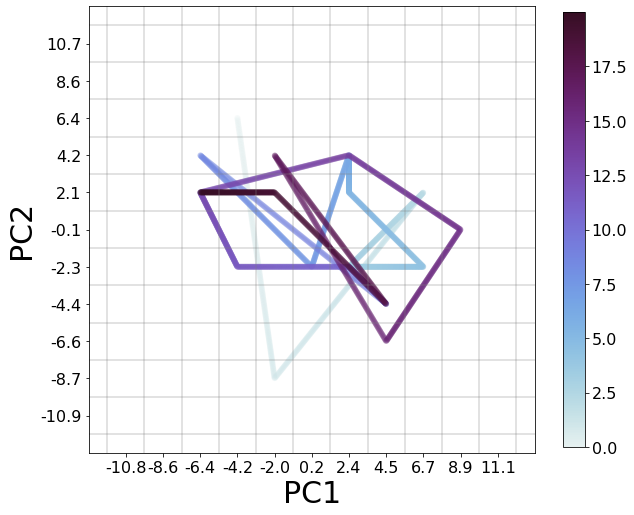

In [68]:
############## fig for CICON #################
from mpl_toolkits.axes_grid1 import make_axes_locatable

norm = matplotlib.colors.Normalize()
cmm = cm.dense


fig, ax = plt.subplots(figsize=(10,10))

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines
    
shortdata = data[10:30].copy()

#interpolate along the trajectory so I can plot dots which will represent the color gradient line
px = shortdata.PC1bins.to_numpy()
py = shortdata.PC2bins.to_numpy()
pz = shortdata.frame.to_numpy()
dist = np.nansum(distance.pdist(shortdata[['PC1bins','PC2bins']]))
fx = interpolate.interp1d(np.arange(1,len(px)+1),px)
newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(5*dist)))
fy = interpolate.interp1d(np.arange(1,len(py)+1),py)
newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(5*dist)))
newz = np.arange(0,len(shortdata), len(shortdata)/len(newy))
if len(newz)>len(newy):
    newz = newz[:-1]
#normalize to the colors to the length of the trajectory
norm.autoscale([0,newz.max()])
#plot the actual transitions
ax.scatter(newx,newy, color = cmm(norm(newz)), alpha = 0.3, edgecolors='none')


ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 16)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 16)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(ax, cax=cax, orientation='vertical')

cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmm),shrink=0.8)
cb.ax.tick_params(labelsize=16)
# plt.show()

plt.savefig(savedir + 'example trajectory.png', bbox_inches='tight')

In [56]:
plt.cm.ScalarMappable(norm=norm, cmap=cmm)

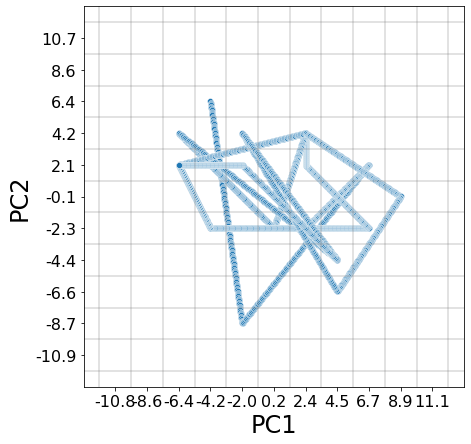

In [49]:
############## fig for CICON #################
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns


norm = matplotlib.colors.Normalize()
cmm = cm.dense



shortdata = data[10:30].copy()

#interpolate along the trajectory so I can plot dots which will represent the color gradient line
px = shortdata.PC1bins.to_numpy()
py = shortdata.PC2bins.to_numpy()
pz = shortdata.frame.to_numpy()
dist = np.nansum(distance.pdist(shortdata[['PC1bins','PC2bins']]))
fx = interpolate.interp1d(np.arange(1,len(px)+1),px)
newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(5*dist)))
fy = interpolate.interp1d(np.arange(1,len(py)+1),py)
newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(5*dist)))
newz = np.arange(0,len(data), len(data)/len(newy))
if len(newz)>len(newy):
    newz = newz[:-1]
#normalize to the colors to the length of the trajectory
norm.autoscale([0,newz.max()])


fig, ax = plt.subplots(1,1,figsize=(7,7))
#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

frame = pd.DataFrame(list(zip(newx,newy)),columns=['x','y'])
#plot the actual transitions
sns.scatterplot(data=frame, x='x', y='y', cmap = cmm(norm(newz))[:,:3], edgecolors='none', ax=ax)


ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 24)
ax.set_ylabel('PC2', fontsize = 24)
ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 16)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 16)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)



plt.show()
#make the directory to save this combined image

# plt.savefig(specificdir + 'entire_transition_trajectory.png', bbox_inches='tight')

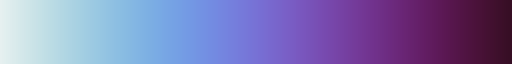

In [50]:
cmm